In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output
from gs_util import IQR_compare,obs_sim

# Read and transfer data

In [11]:
def func_parse_date(Year, DOY, hours, minutes):
        dt = pd.to_datetime(' '.join(
            [str(k) for k in [Year, DOY, hours, minutes]]),
            format='%Y %j %H %M')
        return dt

df=pd.read_csv('data/lake/FxMt_SWL_2015_30m_01/FxMt_SWL_2015_30m_01.csv')
df=df.drop(0,axis=0)
hours=[]
minutes=[]
for x in df.TIME:
    if len(x)==2:
        hour=0
        minute=int(x)
    elif len(x)==3:
        hour=int(x[0])
        minute=int(x[1:])
    elif len(x)==4:
        hour=int(x[0:2])
        minute=int(x[2:])
    if hour==24:
        hour=0
    hours.append(hour)
    minutes.append(minute)
    
df['hours']=hours
df['minutes']=minutes

df=df.astype(float)
#df=df.replace(-99999,np.nan)
df['datetime']=df.apply(lambda x: func_parse_date(int(x['Year']),int(x.DOY),int(x.hours),int(x.minutes)),axis=1)
df=df.set_index('datetime')


df_period=df

df_period=df_period.replace(-99999,np.nan).resample('1h').mean().replace(np.nan,-99999)

input_columns=['iy', 'id', 'it', 'imin', 'qn', 'qh', 'qe', 'qs', 'qf', 'U', 'RH', 'Tair', 'pres', 'rain', 
'kdown', 'snow', 'ldown', 'fcld', 'wuh', 'xsmd', 'lai', 'kdiff', 'kdir', 'wdir']
df_input=pd.DataFrame(columns=input_columns)
df_input.iy=df_period.index.year
df_input.id=[x.timetuple().tm_yday for x in df_period.index]
df_input.it=df_period.index.hour
df_input.imin=df_period.index.minute
df_input['kdown']=df_period.Rg.values
df_input['ldown']=df_period.Rgl.values
df_input['U']=df_period.WS.values
df_input['snow']=0
df_input['rain']=0
df_input['RH']=df_period.Rh.values
df_input['Tair']=df_period.Ta.values
df_input['pres']=df_period.Pa.values
df_input['qf']=0
df_input.qn=df_period.Rn.values

df_input=df_input.replace(-99999,np.nan)

for i in ['rain','U','RH','pres']:
    df_input.loc[df_input[df_input[i]<0].index,i]=-999
    
    df_input.loc[df_input[df_input['Tair']<-50].index,'Tair']=-999
df_input.fillna(-999,inplace=True)

df.replace(-99999,np.nan,inplace=True)

# Analysis

## Calculating albedo

In [12]:
name='SWL'
df_input.to_csv('runs/data/'+name+'_data_60.txt',sep=' ',index=0)

In [13]:
copyfile("./runs/data/" + name + "_" + "data_60.txt",
             "runs/run/input/Kc_2012_data_60.txt")

'runs/run/input/Kc_2012_data_60.txt'

In [14]:
path_runcontrol = Path('runs/run' + '/') / 'RunControl.nml'
#df_state_init = sp.init_supy(path_runcontrol)
df_state_init, df_forcing = sp.load_SampleData()
grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

2020-02-06 14:33:40,981 — SuPy — INFO — All cache cleared.
2020-02-06 14:33:43,349 — SuPy — INFO — All cache cleared.


In [15]:
date1='2015 04 15'
date2='2015 08 01'
df_forcing_run_2=df_forcing_run.loc[date1:date2]
df_forcing_run_2=df_forcing_run_2.replace(-9990,-999)
pm=df_forcing_run_2[df_forcing_run_2.pres>900].pres.median()
df_forcing_run_2.loc[df_forcing_run_2[df_forcing_run_2.pres<900].index,'pres']=pm

a=df_forcing_run_2[df_forcing_run_2.U<0].U
df_forcing_run_2.loc[a.index,'U']=np.nan
df_forcing_run_2.U=sp.util.fill_gap_all(df_forcing_run_2.U)


a=df_forcing_run_2[df_forcing_run_2.Tair<-50].Tair
df_forcing_run_2.loc[a.index,'Tair']=np.nan
df_forcing_run_2.Tair=sp.util.fill_gap_all(df_forcing_run_2.Tair)

a=df_forcing_run_2[df_forcing_run_2.RH<0].RH
df_forcing_run_2.loc[a.index,'RH']=np.nan
df_forcing_run_2.RH=sp.util.fill_gap_all(df_forcing_run_2.RH)

In [16]:
df_1=df.loc[date1:date2]
albedo=df_1.Rg_out/df_1.Rg
alb=albedo[albedo.between(0,1)]
albedo_median=alb[(alb.index.hour>10)&(alb.index.hour<14)].median()
albedo_median

0.04653899168079707

## Changing `df_state_init`

In [17]:
df_state_init.loc[:,'state_id']=[0,0,0,0,0,0,20000]
df_state_init.loc[:,'sfr']=[0,0,0,0,0,0,1]
df_state_init.loc[:,'lat']=36.046561
df_state_init.loc[:,'lng']=138.108386
temp=df_state_init.loc[:,'alb'].values[0]
temp[-1]=albedo_median
df_state_init.loc[:,'alb']=temp
df_state_init.loc[:, 'emissionsmethod'] = 0
df_state_init.loc[:,'roughlenheatmethod']=1
df_state_init.loc[:,'roughlenmommethod']=1
df_state_init.loc[:,'netradiationmethod']=1
df_state_init.loc[:,'z0m_in']=.01
df_state_init.loc[:,'zdm_in']=0
df_state_init.loc[:, 'z']=3
df_state_init.snowuse=0

# OHM coefficients

Need to tune to have the best QS fit

In [18]:
a=df_state_init.loc[:,'ohm_coef'].values[0]
for i in [0,1,2,3]:
    s=6
    a1=0.88
    a2=0.37
    a3=-85.39
    a[(s)*4*3+((i)*3)+(0)]=a1
    a[(s)*4*3+((i)*3)+(1)]=a2
    a[(s)*4*3+((i)*3)+(2)]=a3

df_state_init.loc[:,'ohm_coef']=a

# Test and plot

In [19]:
df_output, df_state_final = sp.run_supy(df_forcing_run_2,
                                        df_state_init,
                                        save_state=False)

2020-02-06 14:33:53,127 — SuPy — INFO — ====================
2020-02-06 14:33:53,130 — SuPy — INFO — Simulation period:
2020-02-06 14:33:53,131 — SuPy — INFO —   Start: 2015-04-15 00:00:00
2020-02-06 14:33:53,132 — SuPy — INFO —   End: 2015-08-01 23:55:00
2020-02-06 14:33:53,134 — SuPy — INFO — 
2020-02-06 14:33:53,136 — SuPy — INFO — No. of grids: 1
2020-02-06 14:33:53,137 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:34:05,111 — SuPy — INFO — Execution time: 12.0 s
2020-02-06 14:34:05,112 — SuPy — INFO — ====================



In [20]:
out=df_output.SUEWS.loc[grid]

df_an=df.loc[date1:date2]
out=out.loc[df_an.index]

df_an=df_an.resample('1h',closed='right',label='left').mean()
out=out.resample('1h').mean()

df_an['qs']=df_an.Rn-df_an.LE-df_an.H


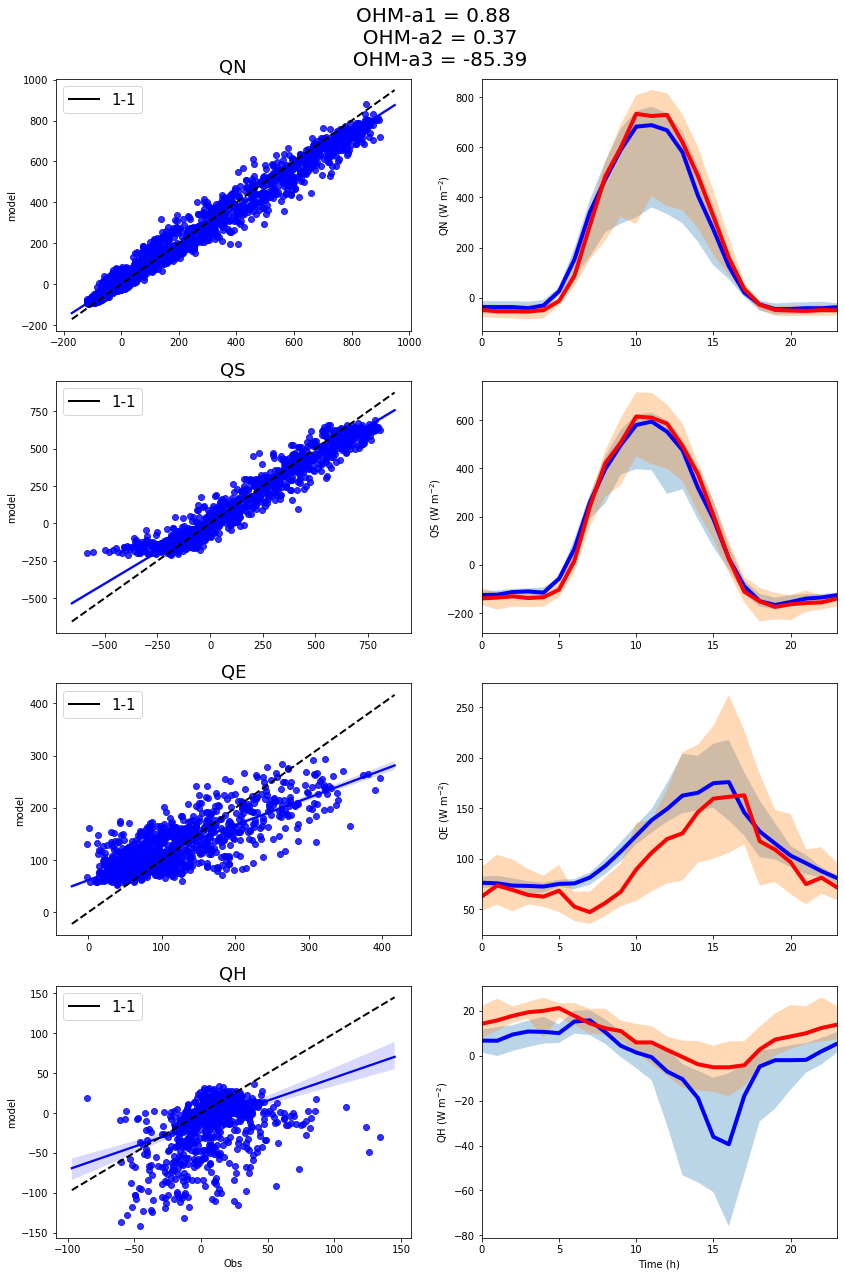

In [21]:
var_meas=['Rn','qs','LE','H']
var_model=['QN','QS','QE','QH']

fig,axs=plt.subplots(len(var_meas),2,figsize=(14,20))
plt.rc('font', size=15)
fig.suptitle('OHM-a1 = '+str(a1)+'\n  OHM-a2 = '+str(a2)+'\n  OHM-a3 = '+str(a3),size=20)
fig.subplots_adjust(top=0.93)
counter=-1
for varmeas,varmodel in zip(var_meas,var_model):
    counter=counter+1
    
    meas=df_an[varmeas].dropna()
    

    ax=axs[counter][0]
    temp=df_an.loc[meas.index]
    aa=out.loc[temp.index][varmodel].dropna()
    obs_sim(varmeas,varmodel,temp.loc[aa.index],out.loc[aa.index],ax)
    ax.set_ylabel('model')
    if counter==len(var_model)-1:
        ax.set_xlabel('Obs')
    ax.set_title(varmodel)

    ax=axs[counter][1]
    IQR_compare(varmeas,varmodel,temp,out.loc[temp.index],ax)
    if counter==len(var_model)-1:
        ax.set_xlabel('Time (h)')
    ax.set_ylabel(varmodel+' (W m$^{-2}$)')

# Writing in pickle files

In [22]:
all_data={}
all_data['model']=out.QE
all_data['obs']=df_an.LE
with open('outputs/surface_conductance/'+name+'-2015.pkl','wb') as f:
    pickle.dump(all_data, f)